<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/3_PyTorchNeuralNetwork/Pytorch_MnistAddition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Neural Network
Write a neural network that can:
- take 2 inputs:
  - an image from MNIST dataset, and
  - a random number between 0 and 9
- and gives two outputs:
  - the "number" that was represented by the MNIST image, and
  - the "sum" of this number with the random number that was generated and sent as the input to the network 

#Import Libraries

In [ ]:
from keras.datasets import mnist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import random
import torch
import numpy as np
from matplotlib import pyplot

In [ ]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
class MNistDataset(Dataset):
    def __init__(self, image,label):
        self.image = image
        self.label=label
    
    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        image = torchvision.transforms.functional.to_tensor(self.image[index])

        label = self.label[index]
        
        #Create one hot encoding for mnist 
        rnum_ohe = torch.zeros(11).long()
        rnum=random.randint(0,9)
        rnum_ohe[rnum] = 1
        rnum_ohe = rnum_ohe[:-1]

        #add actual label and random number
        sum=label+rnum

        return image,label,rnum_ohe,sum

In [ ]:
train_dataset = MNistDataset(x_train, y_train)
test_dataset = MNistDataset(x_test, y_test)

In [ ]:
len(train_dataset),len(test_dataset)

(60000, 10000)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=128)

## View Sample batch

In [ ]:
for i,batch in enumerate(train_loader):
  image,label,random_number, Sum =batch
  print(image.shape)
  print(label)
  print(random_number.shape)
  print(random_number)
  print(Sum)
  break

torch.Size([128, 1, 28, 28])
tensor([3, 8, 6, 0, 7, 5, 0, 1, 5, 3, 0, 9, 5, 9, 6, 4, 4, 3, 0, 9, 0, 2, 4, 1,
        9, 1, 4, 9, 1, 8, 0, 9, 0, 8, 7, 2, 0, 1, 5, 9, 1, 6, 4, 7, 0, 6, 2, 0,
        9, 0, 0, 3, 9, 7, 5, 2, 5, 3, 1, 8, 2, 5, 8, 2, 7, 5, 5, 7, 1, 7, 5, 7,
        7, 3, 1, 7, 1, 7, 3, 1, 3, 8, 3, 8, 1, 2, 5, 5, 9, 9, 6, 2, 2, 3, 1, 3,
        1, 5, 1, 1, 5, 3, 9, 0, 4, 7, 6, 1, 3, 1, 6, 7, 0, 4, 6, 4, 9, 7, 0, 1,
        2, 6, 8, 5, 1, 8, 6, 9], dtype=torch.uint8)
torch.Size([128, 10])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0]])
tensor([ 9,  8,  7,  8,  9,  9,  2,  4,  8,  6,  9, 18,  5, 14, 15, 11,  5, 10,
         3, 15,  0,  7, 11,  3, 15, 10,  9, 14,  7, 15,  6, 14,  1, 11, 10,  5,
         0,  7, 13, 16,  9,  6,  7, 16,  0,  8,  3,  3, 14,  0,  0, 10, 10, 16,
         8,  7, 11,  5,  7, 11,  5,  5,

# Neural Network Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1  Output:26 * 26 * 32 GRF:3 * 3 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 26*26*32 Output:24 * 24 * 64 GRF:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 24*24*64 Output:12 * 12 * 64 GRF:10*10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 28*28*1  Output:26 * 26 * 32 GRF:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 28*28*1  Output:26 * 26 * 32 GRF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 28*28*1  Output:26 * 26 * 32 GRF:28*28
        self.conv5 = nn.Conv2d(256, 512, 3)               #Input: 28*28*1  Output:26 * 26 * 32 GRF:30*30
        self.conv6 = nn.Conv2d(512, 1024, 3)              #Input: 28*28*1  Output:26 * 26 * 32 GRF:32*32
        self.conv7 = nn.Conv2d(1024, 10, 3)               #Input: 28*28*1  Output:26 * 26 * 32 GRF:34*34
        self.fc1 = nn.Linear(10+10, 128)
        self.fc2 = nn.Linear(128,19)

    def forward(self, x,x2):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        
        x = x.view(-1, 10)

        #concatenate second input 
        x_concat = torch.cat((x, x2), dim=1)

        # Further train the network on Dense Layer
        x_fc1 = F.relu(self.fc1(x_concat))
        x_sum = self.fc2(x_fc1)

        #Model returns two outputs:
          #Output1 : "number" represented by the MNIST image 
          #Output2 : "sum" of this number with the random number that was generated
        return F.log_softmax(x),F.log_softmax(x_sum)

In [ ]:
# move the model to the specified device
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=19, bias=True)
)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,384,925 trainable parameters


#Training Loop

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()

    epoch_loss = 0

    # run for all the data in train_loader
    for batch_idx, (data, target, random_number, sum) in enumerate(train_loader):

        # fetch the data and the target values
        target = target.type(torch.LongTensor)
        sum = sum.type(torch.LongTensor)

        # move the data to device
        data, target, sum = data.to(device), target.to(device), sum.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output1,output2 = model(data,random_number.to(device))

        # compute the loss occured
        loss1 = F.nll_loss(output1, target)
        loss2 = F.nll_loss(output2, sum)
        loss= (loss1 + loss2)/2

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()
    print('Train set: Average loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss



## Testing Loop

In [ ]:
def test(model, device, test_loader):
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct1 = 0
    correct2 = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for (data, target, random_number, sum) in test_loader:

            # move the data to device
            target = target.type(torch.LongTensor)
            sum = sum.type(torch.LongTensor)
            data, target,sum = data.to(device), target.to(device), sum.to(device)

            # forward pass the model and get the output
            output1,output2 = model(data,random_number.to(device))

            # accumulate the loss from both the network outputs
            test_loss += (F.nll_loss(output1, target, reduction='sum').item() + F.nll_loss(output2, sum, reduction='sum').item())/2

            # get the index of max log-probability
            pred1 = output1.argmax(dim=1, keepdim=True)
            pred2 = output2.argmax(dim=1, keepdim=True)

            # increment the correct prediction count if pred is correct
            correct1 += pred1.eq(target.view_as(pred1)).sum().item()
            correct2 += pred2.eq(sum.view_as(pred2)).sum().item()


    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.3f}, MNist Accuracy:{100. * correct1/len(test_loader.dataset)}, Sum_Accuracy:{100. * correct2/len(test_loader.dataset)}')

    return test_loss


In [ ]:
# move the model to the specified device
model = Net().to(device)

# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 30

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    # test the model
    test_loss = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    valid_loss_values.append(test_loss)


Epoch 1 : 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train set: Average loss: 2.2796
Test set: Average loss: 2.291, MNist Accuracy:60.74, Sum_Accuracy:10.58

Epoch 2 : 
Train set: Average loss: 1.3755
Test set: Average loss: 1.304, MNist Accuracy:94.85, Sum_Accuracy:12.88

Epoch 3 : 
Train set: Average loss: 1.2010
Test set: Average loss: 1.207, MNist Accuracy:96.74, Sum_Accuracy:17.02

Epoch 4 : 
Train set: Average loss: 1.1480
Test set: Average loss: 1.149, MNist Accuracy:97.6, Sum_Accuracy:24.65

Epoch 5 : 
Train set: Average loss: 1.1004
Test set: Average loss: 1.083, MNist Accuracy:98.04, Sum_Accuracy:34.07

Epoch 6 : 
Train set: Average loss: 0.9960
Test set: Average loss: 1.013, MNist Accuracy:98.31, Sum_Accuracy:48.87

Epoch 7 : 
Train set: Average loss: 0.9677
Test set: Average loss: 0.925, MNist Accuracy:98.51, Sum_Accuracy:61.19

Epoch 8 : 
Train set: Average loss: 0.8425
Test set: Average loss: 0.830, MNist Accuracy:98.82, Sum_Accuracy:75.7

Epoch 9 : 
Train set: Average loss: 0.6937
Test set: Average loss: 0.725, MNist Accur

## Plot the loss function

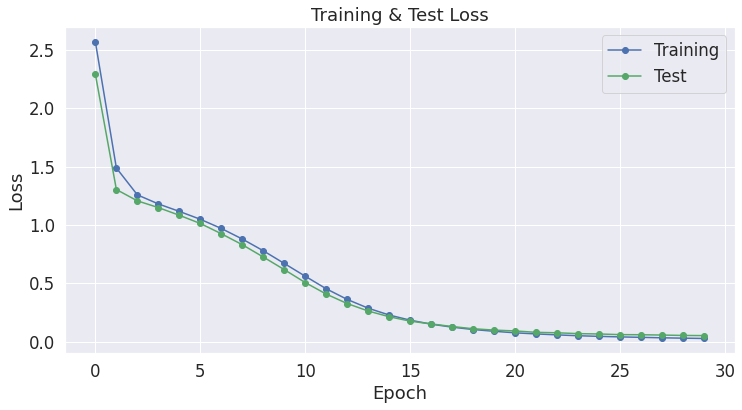

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4])

plt.show()

## Inference

In [ ]:
def prediction(image,rnum):

    rnum_ohe = torch.zeros(11).long()
    rnum_ohe[rnum] = 1
    rnum_ohe = rnum_ohe[:-1]

    tensored_image = torchvision.transforms.functional.to_tensor(image).unsqueeze(dim=1).to(device)
    output_1,output_2 = model(tensored_image,rnum_ohe.reshape(-1,10).to(device))

    pred1 = output_1.argmax(dim=1, keepdim=True)
    pred2 = output_2.argmax(dim=1, keepdim=True)

    print(f"Random Number Generated is {rnum}")
    pyplot.imshow(image, cmap=pyplot.get_cmap('gray'))


    print(f"Mnist Image Prediction:{pred1.item()},\nSum of Mnist and Random Number: {pred2.item()}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Random Number Generated is 1
Mnist Image Prediction:1,
Sum of Mnist and Random Number: 2


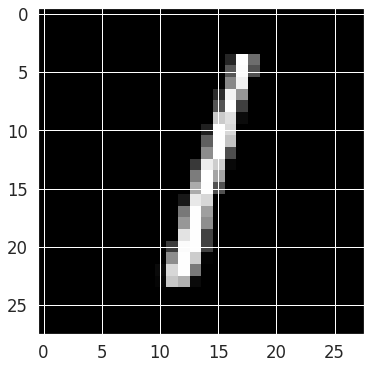

In [ ]:
image = x_test[random.randint(1,100)]
rnum=random.randint(0,9)
prediction(image,rnum)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Random Number Generated is 2
Mnist Image Prediction:4,
Sum of Mnist and Random Number: 6


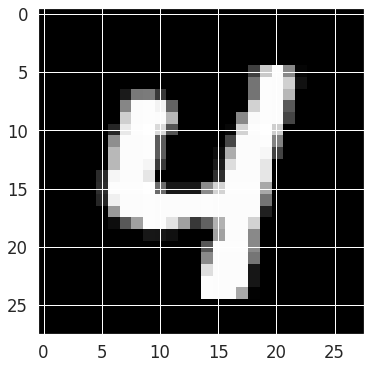

In [ ]:
image = x_test[random.randint(1,1000)]
rnum=random.randint(0,9)
prediction(image,rnum)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Random Number Generated is 9
Mnist Image Prediction:5,
Sum of Mnist and Random Number: 14


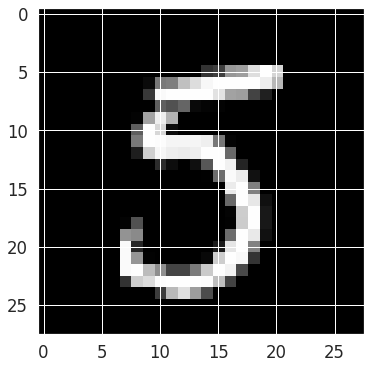

In [ ]:
image = x_test[random.randint(1,1000)]
rnum=random.randint(0,9)
prediction(image,rnum)